In [10]:
#inserisco in un dataframe "df_raw_cycle" la serie temporale del ciclo mestruale del soggetto in esame affetto da ovaio policistico 
#dati estratti dall'app ...
import pandas as pd
import numpy as np
import random
from datetime import timedelta

df_raw_cycle = pd.read_csv('cycle_data.csv')

df_raw_cycle.head()

,date,cycle_flg,black_flg
0,2015-07-08,1,0
1,2015-07-09,1,0
2,2015-07-10,1,0
3,2015-07-11,1,0
4,2015-07-12,1,0


In [11]:
#constructing a dataframe df with cleaned data and with some feature engeneering
df_raw_cycle['date'] = pd.to_datetime(df_raw_cycle['date'], errors='coerce')

# Add row number, day, and month columns
df_raw_cycle['row'] = np.arange(1, len(df_raw_cycle) + 1)
df_raw_cycle['day'] = df_raw_cycle['date'].dt.day
df_raw_cycle['month'] = df_raw_cycle['date'].dt.month

# Reorder columns
df = df_raw_cycle[['row', 'date', 'day', 'month', 'cycle_flg', 'black_flg']]

df.head()

,row,date,day,month,cycle_flg,black_flg
0,1,2015-07-08,8,7,1,0
1,2,2015-07-09,9,7,1,0
2,3,2015-07-10,10,7,1,0
3,4,2015-07-11,11,7,1,0
4,5,2015-07-12,12,7,1,0


In [12]:
#Qui costruiamo un dataframe "df_transformed" pronto per essere usato nell'addestramento di una rete neurale

#nella seguente funzione estraiamo due feature che saranno fondamentali nella predizione del prossimo ciclo mestruale
#la prima è "days_until_next_cycle", che è il numero di giorni che mancano al prossimo ciclo mestruale
#la seconda è "duration_next_cycle", cioè la durata del prossimo ciclo mestruale
def calculate_next_cycle_info(df):
    
    # Sort by date to maintain order
    df = df.sort_values(by='date')
    
    # Initialize columns for days until next cycle and duration of next cycle
    df['days_until_next_cycle'] = None
    df['duration_next_cycle'] = None
    
    # Iterate over each row to calculate the desired values
    for i in range(len(df)):
        current_date = df.loc[i, 'date']
        
        # Find the next cycle start date
        next_cycle_dates = df[(df['date'] > current_date) & (df['cycle_flg'] == 1)]
        if not next_cycle_dates.empty:
            next_cycle_date = next_cycle_dates.iloc[0]['date']
            days_until_next_cycle = (next_cycle_date - current_date).days
            df.at[i, 'days_until_next_cycle'] = days_until_next_cycle
            
            # Find the duration of the next cycle
            next_cycle_end_dates = df[(df['date'] > next_cycle_date) & (df['cycle_flg'] == 0)]
            if not next_cycle_end_dates.empty:
                next_cycle_end_date = next_cycle_end_dates.iloc[0]['date']
                cycle_duration = (next_cycle_end_date - next_cycle_date).days
            else:
                cycle_duration = 1  # If no end date found, assume duration as 1
            
            df.at[i, 'duration_next_cycle'] = cycle_duration
        else:
            df.at[i, 'days_until_next_cycle'] = None
            df.at[i, 'duration_next_cycle'] = None
    
    return df

#questa funzione distribuisce orizzontalmente la serie temporale del diclo mestruale dei precedenti x giorni
#ci saranno quindi x features binarie (cycle_day_1, cycle_day_2, ..., cycle_day_x)
#se cycle_day_i = 1 vuol dire che x-i giorni fa il soggetto ha avuto il ciclo mestruale
def create_time_series(df, x):
    for i in range(1, x+1):
        df[f'cycle_day_{i}'] = df['cycle_flg'].shift(i)
    return df

#di seguito vengono assemblate le precedenti funzioni e vengono scartate tutte le serie temporali che terminano con un ciclo mestruale
#il motivo è che queste serie hanno una predizione banale (se il giorno prima è stato il primo giorno di ciclo, verosimilmente domani ce ne sarà un altro)
#quindi per evitare che la rete neurale si concentri in queste situazioni in cui il valore della predizione è basso
#le scartiamo a priori dal dataset
def transform_dataset(df, x, drop_1):
    df = calculate_next_cycle_info(df)
    df = create_time_series(df, x)
    df['month'] = df['date'].dt.month
    df = df.dropna().reset_index(drop=True)  # Drop rows with NaN values created by shifting
    if drop_1 == True:
        df = df[df['cycle_flg'] != 1]  # Drop rows where cycle_flg is 1
    return df

x = 360  # Number of previous days to include in the time series
df_transformed = transform_dataset(df, x, True)
df_transformed.to_csv('cycle_data_transformed.csv', index=False)


C:\Users\gaeta\AppData\Local\Temp\ipykernel_18992\1575027079.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cycle_day_{i}'] = df['cycle_flg'].shift(i)
C:\Users\gaeta\AppData\Local\Temp\ipykernel_18992\1575027079.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cycle_day_{i}'] = df['cycle_flg'].shift(i)
C:\Users\gaeta\AppData\Local\Temp\ipykernel_18992\1575027079.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [13]:
#costruisco la rete neurale e la addestro dandole in pasto le serie temporali di x giorni e il mese corrente.
#le target feature su cui l'addestro sono days_until_next_cycle e duration_next_cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
#reduce overfitting
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

features = df_transformed[[f'cycle_day_{i}' for i in range(1, x+1)] + ['month']]
target = df_transformed[['days_until_next_cycle', 'duration_next_cycle']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Build the neural network model
input_layer = Input(shape=(X_train_scaled.shape[1],))
dense_layer_1 = Dense(64, activation='relu',kernel_regularizer=l2(0.01))(input_layer)
dense_layer_2 = Dense(32, activation='relu',kernel_regularizer=l2(0.01))(dense_layer_1)
output_layer_1 = Dense(1, name='days_until_next_cycle')(dense_layer_2)
output_layer_2 = Dense(1, name='duration_next_cycle')(dense_layer_2)

model = Model(inputs=input_layer, outputs=[output_layer_1, output_layer_2])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=['mean_squared_error', 'mean_squared_error'],
              metrics={'days_until_next_cycle': 'mean_absolute_error',
                       'duration_next_cycle': 'mean_absolute_error'})

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, 
                    [y_train_scaled[:, 0], y_train_scaled[:, 1]], 
                    epochs=150, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Evaluate the model
loss, days_mae, duration_mae = model.evaluate(X_test_scaled, [y_test_scaled[:, 0], y_test_scaled[:, 1]])

# Make predictions (if needed)
predictions = model.predict(X_test_scaled)
predicted_days_until_next_cycle = scaler_y.inverse_transform(np.concatenate((predictions[0], np.zeros_like(predictions[1])), axis=1))[:, 0]
predicted_duration_next_cycle = scaler_y.inverse_transform(np.concatenate((np.zeros_like(predictions[0]), predictions[1]), axis=1))[:, 1]

print(f"Test MAE for days until next cycle: {days_mae}")
print(f"Test MAE for duration of next cycle: {duration_mae}")

Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - days_until_next_cycle_mean_absolute_error: 0.9815 - duration_next_cycle_mean_absolute_error: 0.8431 - loss: 4.4384 - val_days_until_next_cycle_mean_absolute_error: 0.7706 - val_duration_next_cycle_mean_absolute_error: 0.6524 - val_loss: 3.1365
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - days_until_next_cycle_mean_absolute_error: 0.6099 - duration_next_cycle_mean_absolute_error: 0.5892 - loss: 2.7165 - val_days_until_next_cycle_mean_absolute_error: 0.7095 - val_duration_next_cycle_mean_absolute_error: 0.5845 - val_loss: 2.7904
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - days_until_next_cycle_mean_absolute_error: 0.5307 - duration_next_cycle_mean_absolute_error: 0.4597 - loss: 2.2385 - val_days_until_next_cycle_mean_absolute_error: 0.6625 - val_duration_next_cycle_mean_absolute_error: 0.5654 - val_loss: 2.5972
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - days_until_next_cycle_mean_absolute_error: 0.4763 - dura

In [14]:
#vediamo qualche predizione confrontata con i valori reali
y_test_original = scaler_y.inverse_transform(y_test_scaled)
results_df = pd.DataFrame({
    'true_days_until_next_cycle': y_test_original[:, 0],
    'predicted_days_until_next_cycle': predicted_days_until_next_cycle,
    'true_duration_next_cycle': y_test_original[:, 1],
    'predicted_duration_next_cycle': predicted_duration_next_cycle
})

print(results_df.head(15))


    true_days_until_next_cycle  predicted_days_until_next_cycle  \
0                         16.0                        14.381590   
1                         12.0                        12.848126   
2                         26.0                        27.416306   
3                          7.0                         6.619010   
4                         14.0                        11.597054   
5                         11.0                         9.399019   
6                         20.0                        21.808619   
7                          4.0                         4.964103   
8                          8.0                         8.283577   
9                          6.0                         7.696498   
10                        17.0                        15.240458   
11                        15.0                        10.027300   
12                        16.0                        15.158057   
13                         1.0                         3.98053

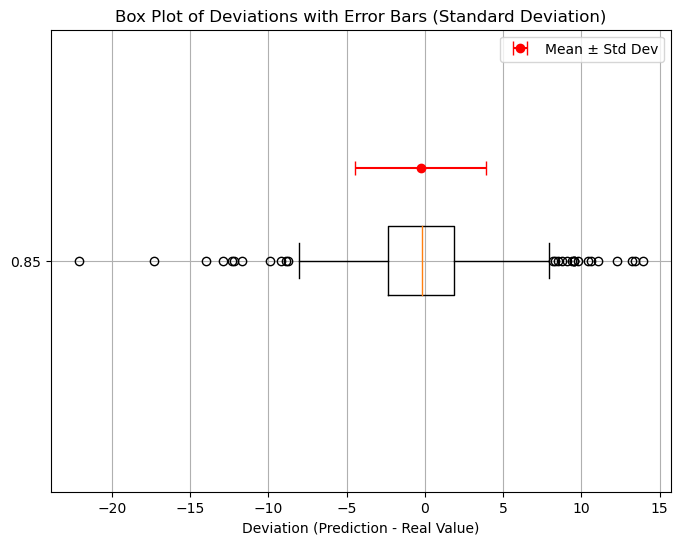

In [15]:
#visualizziamo di quanto deviano le predizioni rispetto ai valori reali in un box plot e con una l'error bar della deviazione

import matplotlib.pyplot as plt

# Calculate deviations
results_df['deviations'] = results_df['true_days_until_next_cycle'] - results_df['predicted_days_until_next_cycle']

# Calculate mean and standard deviation of the deviations
mean_deviation = results_df['deviations'].mean()
std_deviation = results_df['deviations'].std()

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(results_df['deviations'], vert=False, positions=[0.85])

# Plot error bars (mean ± standard deviation) slightly above the box plot
plt.errorbar(x=mean_deviation, y=1.05, xerr=std_deviation, fmt='o', color='red', label='Mean ± Std Dev', capsize=5)

# Add labels and title
plt.title('Box Plot of Deviations with Error Bars (Standard Deviation)')
plt.xlabel('Deviation (Prediction - Real Value)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [16]:
#Di seguito ci assicuriamo che le rete neurale non abbia semplicemente imparato a replicare il rumore dei dati (deviazione standard)

# Assume these are your test set values and model predictions
true_values_days = y_test_original[:, 0]
predicted_values_days = predicted_days_until_next_cycle

true_values_duration = y_test_original[:, 1]
predicted_values_duration = predicted_duration_next_cycle

# Calculate MAE
mae_days = np.mean(np.abs(true_values_days - predicted_values_days))
mae_duration = np.mean(np.abs(true_values_duration - predicted_values_duration))

print(f"MAE for days_until_next_cycle: {mae_days}")
print(f"MAE for duration_next_cycle: {mae_duration}")

# Evaluate against the standard deviation of the target values
std_days = np.std(true_values_days)
std_duration = np.std(true_values_duration)

print(f"Standard deviation of days_until_next_cycle: {std_days}")
print(f"Standard deviation of duration_next_cycle: {std_duration}")

# Comparing MAE to standard deviation
if mae_days < std_days * 0.5:
    print("MAE for days_until_next_cycle is good.")
else:
    print("MAE for days_until_next_cycle could be improved.")

if mae_duration < std_duration * 0.5:
    print("MAE for duration_next_cycle is good.")
else:
    print("MAE for duration_next_cycle could be improved.")

MAE for days_until_next_cycle: 2.968451861947576
MAE for duration_next_cycle: 0.25925706861279324
Standard deviation of days_until_next_cycle: 8.447784483123385
Standard deviation of duration_next_cycle: 0.9550749155978778
MAE for days_until_next_cycle is good.
MAE for duration_next_cycle is good.


In [17]:
df_transformed = transform_dataset(df, x, False)
df_transformed.to_csv('cycle_data_transformed.csv', index=False)

C:\Users\gaeta\AppData\Local\Temp\ipykernel_18992\1575027079.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cycle_day_{i}'] = df['cycle_flg'].shift(i)
C:\Users\gaeta\AppData\Local\Temp\ipykernel_18992\1575027079.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'cycle_day_{i}'] = df['cycle_flg'].shift(i)
C:\Users\gaeta\AppData\Local\Temp\ipykernel_18992\1575027079.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [18]:
row_values = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6]
columns = [f'cycle_day_{i}' for i in range(1, x+1)] + ['month']
df = pd.DataFrame([row_values], columns=columns)
df

,cycle_day_1,cycle_day_2,cycle_day_3,cycle_day_4,cycle_day_5,cycle_day_6,cycle_day_7,cycle_day_8,cycle_day_9,cycle_day_10,...,cycle_day_352,cycle_day_353,cycle_day_354,cycle_day_355,cycle_day_356,cycle_day_357,cycle_day_358,cycle_day_359,cycle_day_360,month
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [19]:
X_new_example = df

# Ensure the same scaling as the training data
X_new_example_scaled = scaler_X.transform(X_new_example)

prediction = model.predict(X_new_example_scaled)
predicted_days_until_next_cycle = scaler_y.inverse_transform(np.concatenate((prediction[0], np.zeros_like(prediction[1])), axis=1))[:, 0]
predicted_duration_next_cycle = scaler_y.inverse_transform(np.concatenate((np.zeros_like(prediction[0]), prediction[1]), axis=1))[:, 1]

print(predicted_days_until_next_cycle[:5])
print(predicted_duration_next_cycle[:5])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[8.051902]
[5.379304]


In [20]:
#Per capire se il modello è in grado di fare delle buone previsioni, confrontiamo le sue prestazioni con un rule-based model
#rule-based model: prevedo che il prossimo ciclo avviene dopo 28 giorni dall'inizio del precedente ciclo
import pandas as pd
from datetime import timedelta
df_rule = transform_dataset(df, x, False)

predictions = []
count = 28
for days_until_next_cycle in df_rule['days_until_next_cycle']:
    if days_until_next_cycle != 1:
        predictions.append(count)
        if count-1>0:
            count-=1
        else:
            count = 1
    else:
        count = 28
        predictions.append(count)

# Append the new row to the DataFrame
df_rule['predictions'] = predictions

KeyError: 'date'

In [ ]:
#di seguito vediamo che il rule-based model performa decisamente peggio della rete neurale
df_rule = df_rule[df_rule['days_until_next_cycle'] != 1]
mae_days = np.mean(np.abs(df_rule['days_until_next_cycle'] - df_rule['predictions']))
mae_days

7.6066964285714285

In [ ]:
#per vedere che il rule-based model funziona correttamente
pd.set_option('display.max_rows', None)
print(df_rule[['days_until_next_cycle','predictions']])

     days_until_next_cycle  predictions
0                       20           28
1                       19           27
2                       18           26
3                       17           25
4                       16           24
5                       15           23
6                       14           22
7                       13           21
8                       12           20
9                       11           19
10                      10           18
11                       9           17
12                       8           16
13                       7           15
14                       6           14
15                       5           13
16                       4           12
17                       3           11
18                       2           10
25                      24           28
26                      23           27
27                      22           26
28                      21           25
29                      20           24
